# Malaria Detection with Raspberry Pi Zero 2W

## Objectives:

Automating the process of detecting Malaria with deep learning aims to provide a rapid, accurate, and accessible diagnostic tool. This technological leap would enable quicker treatment, reduce the burden on healthcare systems, and improve patient outcomes, ultimately saving countless lives by making early and reliable diagnosis available to even the most remote and underserved populations.

## Important Considerations:

- This is just a Proof of Concept project, it needs to be adapted to a specific microscope to work properly.
- It is important to make this product as cheap as possible since Malaria affects mostly under developed countries.
- We need a way to pre-process our data in order to use it as input to the model.

## Imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import zipfile
import os
import kagglehub
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import cv2
import random
import glob
import shutil

/Users/rolds/Documents/venvs/Malaria_venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

## Dataset:

### Description:

The dataset that was used was: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

There are a total of 27560 images (colored) that we have taken from microscopic images. These images are of the following categories:

- Parasitized: The parasitized cells contain the Plasmodium parasite which causes malaria
- Uninfected: The uninfected cells are free of the Plasmodium parasites

### Download the Dataset:

In [3]:
try:
    dataset_path = kagglehub.dataset_download("iarunava/cell-images-for-detecting-malaria")

except Exception as e:
    print(f"Falha ao baixar o dataset: {e}")

In [4]:
print(dataset_path)

/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1


### Preparing the Dataset:

In [5]:
for i in os.listdir(os.path.join(dataset_path, 'cell_images')):
    print(i)

.DS_Store
Parasitized
Uninfected
cell_images


In [6]:
parasitized_path = os.path.join(dataset_path, 'cell_images', 'Parasitized')
uninfected_path = os.path.join(dataset_path, 'cell_images', 'Uninfected')

In [7]:
len(os.listdir(parasitized_path)), len(os.listdir(uninfected_path))

(13780, 13780)

In [8]:
parasitized_files = glob.glob(os.path.join(parasitized_path, '*.png'))
uninfected_files = glob.glob(os.path.join(uninfected_path, '*.png'))

In [9]:
parasitized_files[:5]

['/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C118P79ThinF_IMG_20151002_105018_cell_150.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C189P150ThinF_IMG_20151203_142224_cell_84.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C91P52ThinF_IMG_20150821_123116_cell_189.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C84P45ThinF_IMG_20150818_101226_cell_98.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Parasitized/C144P105ThinF_IMG_20151015_163432_cell_310.png']

In [10]:
len(parasitized_files), len(uninfected_files)

(13779, 13779)

In [11]:
uninfected_files[:5]

['/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/C13NThinF_IMG_20150614_131318_cell_179.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/C205ThinF_IMG_20151106_152003_cell_21.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/C230ThinF_IMG_20151112_150647_cell_1.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/C134P95ThinF_IMG_20151005_121834_cell_65.png',
 '/Users/rolds/.cache/kagglehub/datasets/iarunava/cell-images-for-detecting-malaria/versions/1/cell_images/Uninfected/C141P102ThinF_IMG_20151005_214836_cell_132.png']

In [12]:
test_size_per_class = 2752

np.random.seed(42)

test_p = np.random.choice(parasitized_files, test_size_per_class, replace=False)
test_u = np.random.choice(uninfected_files, test_size_per_class, replace=False)

train_p = list(set(parasitized_files) - set(test_p))
train_u = list(set(uninfected_files) - set(test_u))

In [13]:
x_train = train_p + train_u
y_train = [1] * len(train_p) + [0] * len(train_u) # 1=Para, 0=Unin
x_test = list(test_p) + list(test_u)
y_test = [1] * len(test_p) + [0] * len(test_u)

In [14]:
x_train, y_train = shuffle(x_train, y_train, random_state=42)
x_test, y_test = shuffle(x_test, y_test, random_state=42)

In [15]:
image_size = (64, 64)

for i in range(len(x_train)):
    img = cv2.imread(x_train[i])
    img = cv2.resize(img, image_size)
    x_train[i] = img

for i in range(len(x_test)):
    img = cv2.imread(x_test[i])
    img = cv2.resize(img, image_size)
    x_test[i] = img

In [16]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(22054, 64, 64, 3) (22054,) (5504, 64, 64, 3) (5504,)


### Visualizing Samples:

1


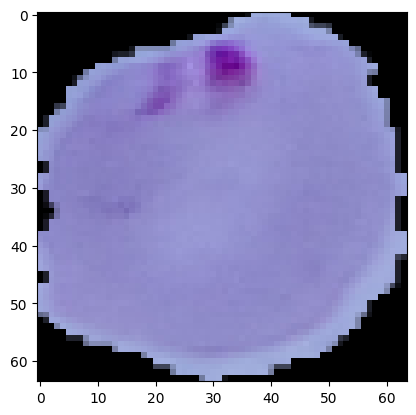

In [17]:
plt.imshow(x_train[0])
print(y_train[0])

0


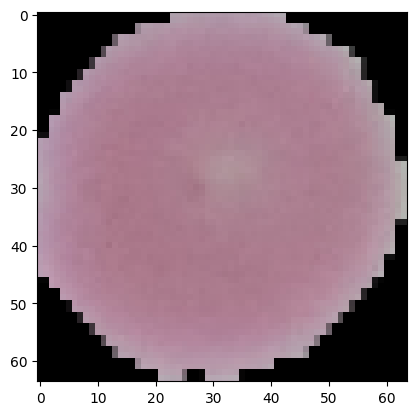

In [18]:
plt.imshow(x_train[4])
print(y_train[4])

0


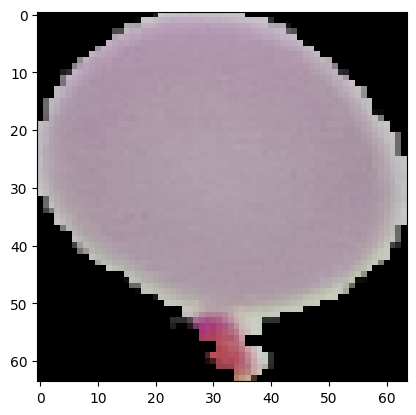

In [19]:
plt.imshow(x_test[0])
print(y_test[0])

1


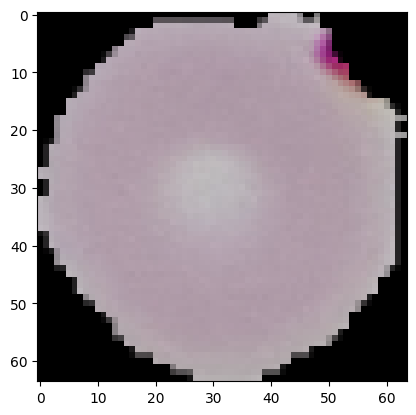

In [20]:
plt.imshow(x_test[1])
print(y_test[1])

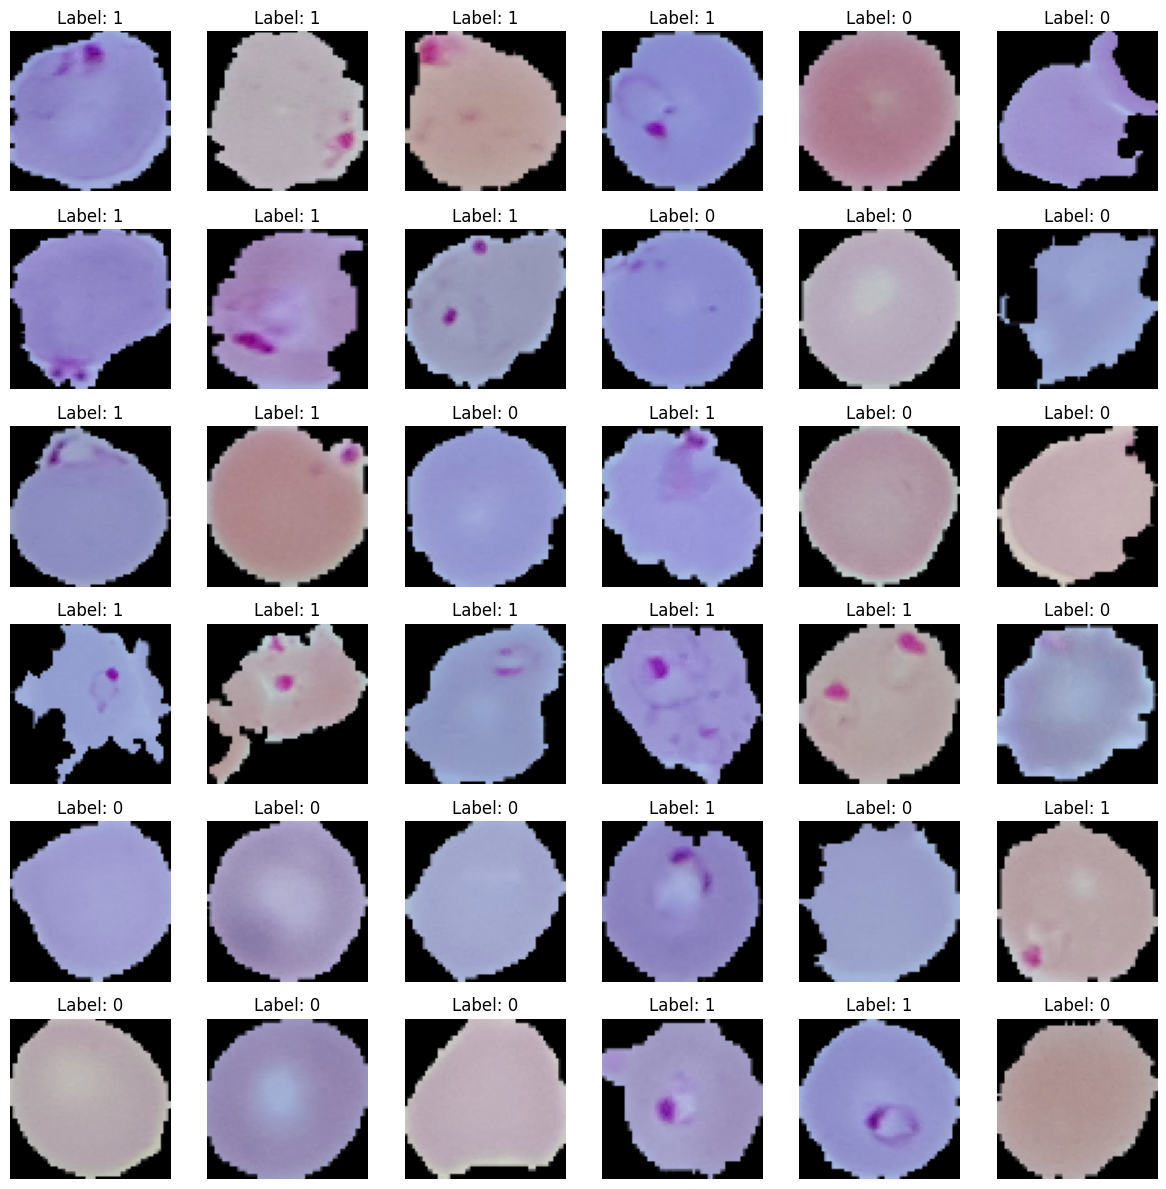

In [26]:
plt.figure(figsize=(12, 12))

for i in range(18):
    plt.subplot(6, 6, i + 1)
    plt.imshow(x_train[i])
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

for i in range(18):
    plt.subplot(6, 6, 18 + i + 1)
    plt.imshow(x_train[-(18 - i)])
    plt.title(f"Label: {y_train[-(18 - i)]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Checking the Distribution:

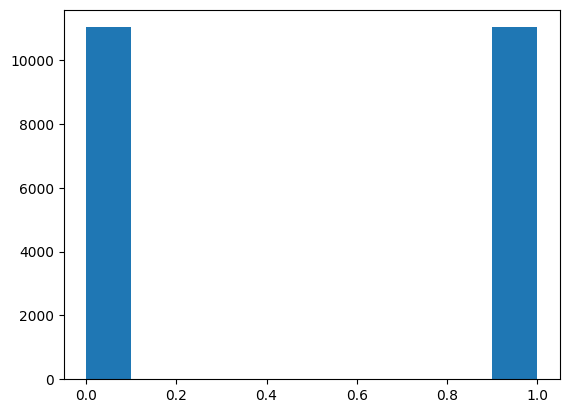

In [21]:
plt.hist(y_train)
plt.show()

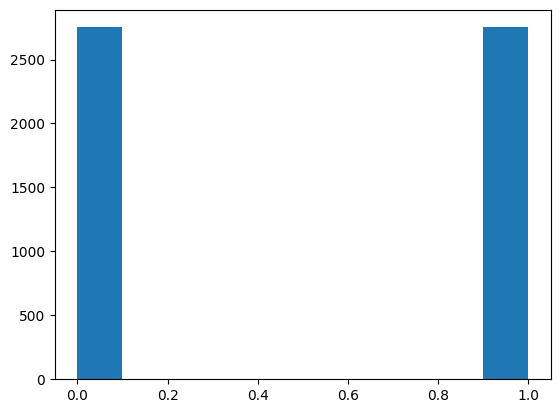

In [22]:
plt.hist(y_test)
plt.show()

### Normalizing the Data:

In [23]:
print("Training data range:", np.min(x_train.flatten()), "-", np.max(x_train.flatten()))
print("Testing data range:", np.min(x_test.flatten()), "-", np.max(x_test.flatten()))

Training data range: 0 - 255
Testing data range: 0 - 255


In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [25]:
print("Training data range:", np.min(x_train.flatten()), "-", np.max(x_train.flatten()))
print("Testing data range:", np.min(x_test.flatten()), "-", np.max(x_test.flatten()))

Training data range: 0.0 - 1.0
Testing data range: 0.0 - 1.0


## Feature testing:

### Converting RGB to HSV of Images using OpenCV:

### Gaussian Blurring: